<a href="https://colab.research.google.com/github/dapopov-st/ExperimentsWithLanguageModels/blob/main/GeneratingMarketingEmailsfromProductNameandDescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Marketing Emails from Product Name and Description

SETTING:
- Use case and approach inspired by Chris Alexiuk's talk: https://www.youtube.com/watch?v=eTieetk2dSw&ab_channel=DeepLearningAI
- Unsupervised fine tuning approach (without SFTTrainer -> Trainer)
- LoRA only, no QLoRA (may want to experiment if can't load mistral-7b-instruct)
- Fine tuning Mistral-7B-Instruct

TAKEAWAYS:
- It's trickier working with the regular Huggingface Trainer compared to trl.SFTTrainer.  For example, BitAndBites config is hard to marry with it.
- Can get smooth training and fast convergence working on A100 for this application. T4 attempts were futile even with rank 4 Lora on Q and V, however,...
- The model trains very fast on A100 with adaptors used on Q and V layers only (original LoRA suggestion)
- With PEFT LoRa, the only weights trained are the ones specified in the config, the other layers remain constant (in fact, Trainer will complain that there is nothing to update the grads on without the LoRA config)
- With ```python "<s>" and "</s>``` (crossout tokens used to not consider instruction in the loss as part of training Mistral) tokens properly placed in the prompt, the model does not go on generating extra tokens after it has generated the response (may have been a gotcha in a previous project)

POSSIBLE TODO:
- Repeat the process here with SFTTrainer.  Currently, the generation speed is rather slow (takes a minute per email).  With Bits and Bytes, could probably get same or better quality and speed it up.

In [1]:
!pip install -U -q "transformers==4.35.0" "datasets==2.12.0" "tokenizers==0.14.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.1"

In [2]:
!pip install -U -q wandb

In [3]:
# fastai function to clean GPU memory
import sys,gc,traceback
import torch
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''


def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')

output_dir = '/content/drive/MyDrive/ExperimentsWithLanguageModels/expllm_output_dir'
logging_dir = '/content/drive/MyDrive/ExperimentsWithLanguageModels/expllm_logging_dir'

%cd /content/drive/MyDrive/ExperimentsWithLanguageModels
!ls .


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ExperimentsWithLanguageModels
adapter_config.json  expllm_output_dir	wandb


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: dpopovvelasco. Use `wandb login --relogin` to force relogin


True

## Prepare the Model and the Tokenizer

In [7]:
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.1"
#model_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"



# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

model_config = transformers.AutoConfig.from_pretrained(MODEL_ID)


model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    config=model_config,
    #quantization_config=bnb_config, #using bnb_config
    device_map='auto',
    torch_dtype=torch.float16,
    load_in_8bit=True,
)
model.gradient_checkpointing_enable()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMS

In [9]:
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32) # for stability
model.gradient_checkpointing_enable() #reduce memory requirements at the cost of extra computation
model.enable_input_require_grads()

#similarly, cast the head to float32 for stability
class CastOutputToFloat(nn.Sequential):
  def forward(self,x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [11]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad: #trainable
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)

trainable params: 0 || all params: 7241732096 || trainable%: 0.0


In [12]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
peft_config = LoraConfig(
    lora_alpha=4,#16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM", #for generative modeling
    target_modules=["q_proj", "v_proj"],

    #target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj","up_proj", "down_proj"],
    #target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
)
model = get_peft_model(model, peft_config)

In [13]:
print_trainable_parameters(model)

#trainable params: 92274688 || all params: 7334006784 || trainable%: 1.2581756564680047 w/ target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"], lora_alpha = 16
#trainable params: 167772160 || all params: 7409504256 || trainable%: 2.264283199029719 w/target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj","up_proj", "down_proj"],  lora_alpha = 16;
#trainable params: 27262976 || all params: 7268995072 || trainable%: 0.3750583915652433,  lora_alpha = 4
#trainable params: 27262976 || all params: 7268995072 || trainable%: 0.3750583915652433  target_modules=["q_proj", "v_proj"], lora_alpha = 4

trainable params: 27262976 || all params: 7268995072 || trainable%: 0.3750583915652433


In [16]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
              (v_p

With bnbconfig and regular transformers.Trainer, get the following error.  SFTTrainer is configured to work well with bnb, don't think it's the case for the regular Trainer.
```python
---------------------------------------------------------------------------

RuntimeError                              Traceback (most recent call last)

<ipython-input-93-704ded3e2280> in <cell line: 6>()
      5 #                  config={**config,**peft_config.to_dict()})
      6 for param in model.parameters():
----> 7     param.requires_grad = True
      8 model.train()
      9

RuntimeError: only Tensors of floating point and complex dtype can require gradients
```

In [14]:
MAX_LEN =2048

# Load the corresponding tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    MODEL_ID,
    return_overflowing_tokens=True, #adding for shape mismatches
    max_len = MAX_LEN,  # This is critical!  Otherwise the model goes on generating [/INST] tokens!!!
    #use_fast=True
)
tokenizer.padding_side = 'right' #Warning stated to use this with decoder-only; however 'left' made trained model worse! Try right again after prompt adjustment
tokenizer.pad_token = tokenizer.eos_token



## Load and Prepare the Data

In [17]:
import transformers
from datasets import load_dataset
DS_NAME = "Isotonic/marketing_email_samples"
dataset = load_dataset(DS_NAME)
print(dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['product', 'description', 'marketing_email'],
        num_rows: 487
    })
    test: Dataset({
        features: ['product', 'description', 'marketing_email'],
        num_rows: 87
    })
})


- Prefer to have more control over train test split and not sure how the original train test split was done, so will merge train and test splits first, then shuffle and split myself

> Indented block



In [18]:
from copy import deepcopy
from datasets import concatenate_datasets
orig_dataset = deepcopy(dataset)
dataset = concatenate_datasets([dataset['train'], dataset['test']])

In [19]:
dataset

Dataset({
    features: ['product', 'description', 'marketing_email'],
    num_rows: 574
})

In [21]:
orig_dataset

DatasetDict({
    train: Dataset({
        features: ['product', 'description', 'marketing_email'],
        num_rows: 487
    })
    test: Dataset({
        features: ['product', 'description', 'marketing_email'],
        num_rows: 87
    })
})

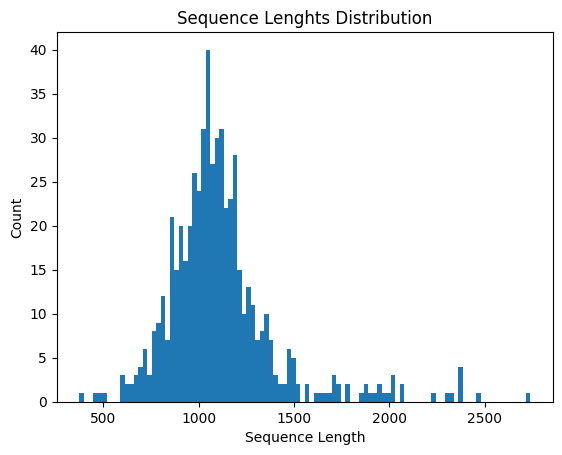

In [22]:
import matplotlib.pyplot as plt
MAX_LEN = 2048
def get_reg_and_long_seq_lengths(dataset):
  seq_lens = []
  seq_long = set()
  for idx, example in enumerate(dataset):
    seq_lens.append(len(example['product']+example['description']+example['marketing_email']))
    if seq_lens[idx] > MAX_LEN:
      seq_long.add(idx)
  return seq_lens, seq_long

def plot_seq_lens(seq_lens):
  plt.hist(seq_lens, bins = 100)
  plt.xlabel("Sequence Length")
  plt.ylabel("Count")
  plt.title("Sequence Lenghts Distribution")
  plt.show()

#seq_lens, seq_long = get_reg_and_long_seq_lengths(orig_dataset['train'])
seq_lens, seq_long = get_reg_and_long_seq_lengths(dataset)

plot_seq_lens(seq_lens)

In [23]:
print(f"Percentage of sequences over {MAX_LEN}: {len(seq_long)*100/len(seq_lens)}%")
print(f"Min and max length sequences: {min(seq_lens)}, {max(seq_long)}")


Percentage of sequences over 2048: 1.916376306620209%
Min and max length sequences: 375, 538


- Well, betting on most people not reading marketing emails over 2048 tokens long.

In [24]:
## SEEING if <s> tokens are the reason why stuff was not ending with title gen in Mistral finetune
def format_prompt(sample):
    """Given a sample dictionary with keys "product","description" and "marketing_email" format into a prompt.

    Args:
      sample: A sample dictionary from a Hugging Face dataset.

    Returns:
      sample: sample dictionary with "text" key for the formatted prompt.
    """
    sample['text']=(f"<s>[INST] Write a marketing email for the following product and description.\n\n \
    ### Product:\n{sample['product']}\n### Description:\n{sample['description']}\n\n### Marketing Email:\n[/INST]{sample['marketing_email']}</s>"
    )
    return sample

In [25]:
VAL_SIZE = 0.05 # choosing smaller size to reduce validation time
def preprocess_dataset(dataset):
          return (dataset
          .select(i for i in range(len(dataset)) if i not in seq_long)
          .shuffle(1337)
          .train_test_split(test_size=VAL_SIZE)
          .map(format_prompt, remove_columns=['product', 'description', 'marketing_email'])
          .map(lambda sample: tokenizer(sample['text']),batched=True)
          .remove_columns('text'))
          #.map(lambda samples: tokenizer(samples['text'], truncation=True, padding=True))
dataset = preprocess_dataset(dataset)
#dataset = dataset.map(lambda samples: tokenizer(generate_prompt(samples['product'], samples['description'], samples['marketing_email'])))

Map:   0%|          | 0/534 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/534 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 534
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 29
    })
})

- The number of steps displayed will be the number of gradient update steps.  For example, if do one epoch and 16 steps per gradient update, can cover 538ish samples in 528/16 = 33 steps.

- OK, now have 'input_ids' and 'attention_mask' columns, which are the only columns the Trainer needs.

## Train and Generate

In [28]:
# run = wandb.init(project="mistral7b_marketing_finetune",
#                  name = f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",
#                  job_type="Finetuning",
#                  save_code=True,
#                  config={**config,**peft_config.to_dict()})
# for param in model.parameters():
#     param.requires_grad = True
# model.train()

trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset['test'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,#2,
        per_device_eval_batch_size=4,#2,
        gradient_accumulation_steps=4,#8,
        max_grad_norm=0.3,          #Implement gradient clipping for training stability
        warmup_steps=100,
        num_train_epochs = 3.0,
        #max_steps=100,
        save_strategy="steps",       # Save the model checkpoint every logging step
        evaluation_strategy="steps", # Evaluate the model every logging step
        save_steps=10,
        learning_rate=5e-5,#1e-3,
        fp16=True,
        logging_steps=10,
        output_dir=output_dir,
        logging_dir=logging_dir,
        report_to='wandb'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
#wandb.finish()


Step,Training Loss,Validation Loss
10,1.775500,1.827549
20,1.751800,1.812163
30,1.768100,1.790657
40,1.708500,1.758768
50,1.674900,1.717585
60,1.641700,1.660932
70,1.586200,1.592965
80,1.517100,1.507482
90,1.399700,1.404411


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain 

TrainOutput(global_step=99, training_loss=1.615294803272594, metrics={'train_runtime': 1096.8067, 'train_samples_per_second': 1.461, 'train_steps_per_second': 0.09, 'total_flos': 2.585644108770509e+16, 'train_loss': 1.615294803272594, 'epoch': 2.96})

In [29]:
model_name = "Mistral7bInstruct-MarketingEmailAdaptor4QV"
HUGGINGFACE_USER_NAME = "dpv"

model.push_to_hub(f"{HUGGINGFACE_USER_NAME}/{model_name}", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:853: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dpv/Mistral7bInstruct-MarketingEmailAdaptor4QV/commit/1b7ac55c37894cea763a7009104f7c588d04bbbf', commit_message='Upload model', commit_description='', oid='1b7ac55c37894cea763a7009104f7c588d04bbbf', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
clean_mem()

In [31]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = f"{HUGGINGFACE_USER_NAME}/{model_name}"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
dir(config)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_repo',
 '_get_files_timestamps',
 '_get_peft_type',
 '_split_kwargs',
 '_upload_modified_files',
 'auto_mapping',
 'base_model_name_or_path',
 'from_json_file',
 'from_pretrained',
 'inference_mode',
 'peft_type',
 'push_to_hub',
 'revision',
 'save_pretrained',
 'task_type',
 'to_dict']

In [43]:
from IPython.display import display, Markdown

def make_inference(product, description):
  batch = tokenizer(f"<s>[INST] Write a marketing email for the following product and description.\n\n \
    ### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n[/INST]", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))
  #Skip special_tokens=False else the text comes out crossed out!

In [44]:
your_product_name_here = "MS Amazing"
your_product_description_here = "A personalized marketing postcard to trigger reactivation and to convert website visitors to customers!"

make_inference(your_product_name_here, your_product_description_here)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Write a marketing email for the following product and description.

     ### Product:
MS Amazing
### Description:
A personalized marketing postcard to trigger reactivation and to convert website visitors to customers!

### Marketing Email:
[/INST] Subject: Get ready to convert with MS Amazing!

Dear [Name],

Are you looking for a way to boost your website traffic and convert more visitors into customers? Look no further than MS Amazing!

Our personalized marketing postcard is the perfect tool to reactivate old customers and attract new ones. With a unique design and customized message, your postcard will stand out in the mail and catch the attention of your target audience.

Don't let your website visitors go to waste. With MS Amazing, you can turn them into loyal customers and drive more sales for your business. Order now and start seeing results in no time!

Best regards,
[Your Name]

In [45]:
your_product_name_here = "MS Amazing"
your_product_description_here = "Providing personalized, just-in-time retargeting, Bam There is a truly omnipresent marketing workhorse"

make_inference(your_product_name_here, your_product_description_here)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Write a marketing email for the following product and description.

     ### Product:
MS Amazing
### Description:
Providing personalized, just-in-time retargeting, Bam There is a truly omnipresent marketing workhorse

### Marketing Email:
[/INST] Subject: Get Personalized Retargeting with MS Amazing

Dear [Name],

Are you tired of generic retargeting ads that don't resonate with your audience? Look no further than MS Amazing! Our personalized, just-in-time retargeting solution is the ultimate marketing workhorse.

With MS Amazing, you can target your ads to specific individuals based on their browsing history, interests, and more. And with our just-in-time technology, your ads will appear at the exact moment your audience is most likely to be interested in them.

Don't settle for generic retargeting ads that don't deliver results. Try MS Amazing today and see the difference for yourself!

Best regards,
[Your Name]